# Imports and define expectation func

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation, plot_distribution
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.train_AIS import AIS_trainer
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
import torch

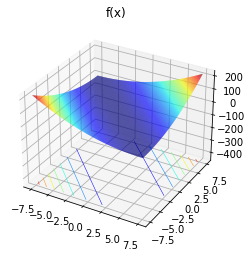

In [3]:
# setup expectation function
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Let's start with Guassian Problem

## Setup

In [18]:
torch.manual_seed(2)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = Guassian_FullCov(dim=dim)

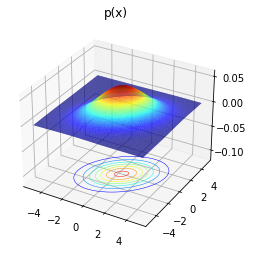

In [19]:
fig = plot_distribution(target)

In [20]:
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
true_expectation

tensor(8.2108)

## Flow with DReG

In [31]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, flow_type="RealNVP", n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

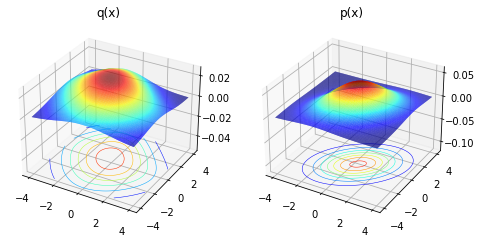

In [32]:
fig_before_train = plot_distributions(tester)

In [33]:
history = tester.train(epochs, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: 0.0225563682615757, mean log p_x -3.8588311672210693: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 174.03it/s]

estimate before training is 8.387176513671875 
estimate after training is 8.191076278686523 
effective sample size is 9962.7041015625 
variance in weights is 3.743822959978438e-11


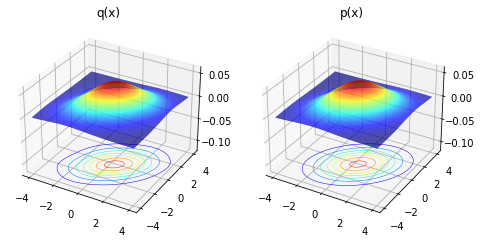

In [34]:
fig_after_train = plot_distributions(tester)

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

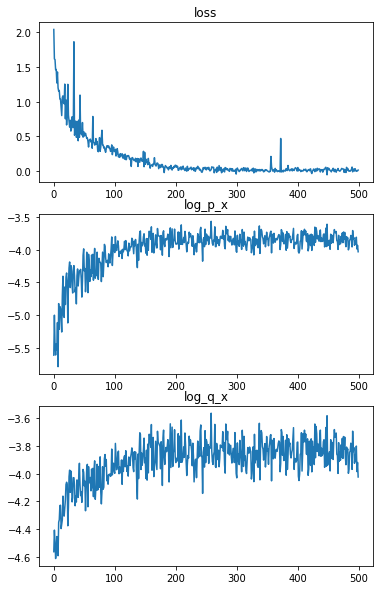

In [35]:
plot_history(history)

## Flow with kl

In [36]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, flow_type="RealNVP", n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

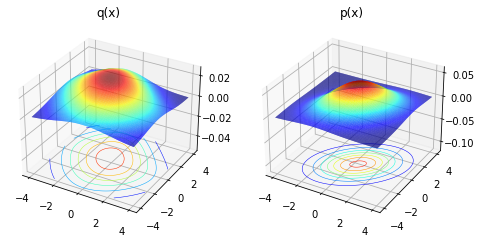

In [37]:
fig_before_train = plot_distributions(tester)

In [38]:
history = tester.train(epochs, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: 0.01015071664005518, mean log p_x -3.908512830734253: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 174.95it/s]

estimate before training is 8.387176513671875 
estimate after training is 8.14413833618164 
effective sample size is 9947.00390625 
variance in weights is 5.328593816189553e-11


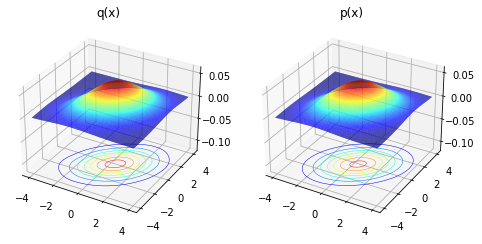

In [39]:
fig_after_train = plot_distributions(tester)

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

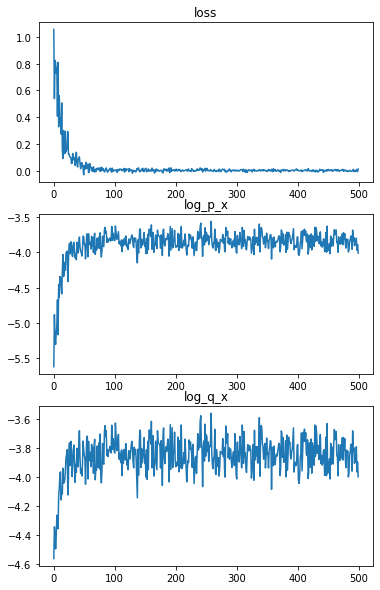

In [40]:
plot_history(history)

## Let's compare to our standard diagonal guassian case to show that flows help

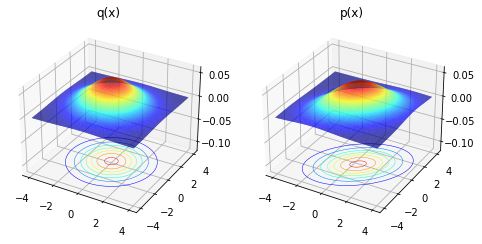

In [41]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation()

loss: 1.2376959323883057, mean log p_x -4.036707878112793: 100%|███████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 376.93it/s]


true expectation is 0.16873280704021454 
estimate before training is 0.11744829267263412 
estimate after training is 0.19108514487743378 
effective sample size is 8289.0439453125 
variance in weights is 2.0643291520627827e-09


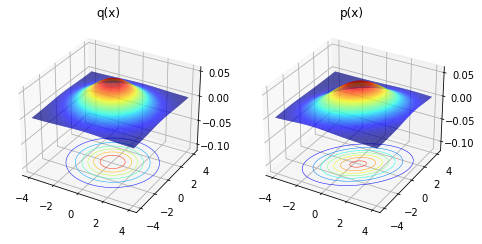

In [42]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation)
true_expectation = torch.sum(tester.target_dist.mean)

print(f"true expectation is {true_expectation} \n"
      f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

# Now let's do some MoG

## Setup

In [4]:
torch.manual_seed(2)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=2, min_cov=2)

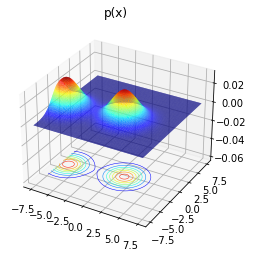

In [5]:
fig = plot_distribution(target, range=15)

## DReG

In [56]:
epochs = 5000

In [57]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=10) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") #"DReG"
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

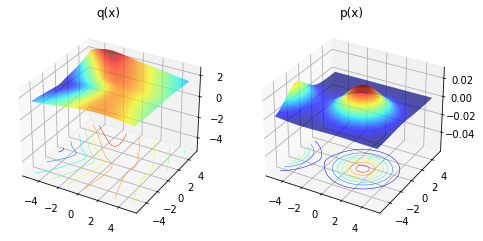

In [58]:
fig_before_train = plot_distributions(tester)

In [59]:
#tester.optimizer = torch.optim.Adam(tester.learnt_sampling_dist.parameters(), lr=1e-4)
# tester.optimizer.param_groups[0]["lr"]

In [ ]:
history = tester.train(epochs, batch_size=400)

loss: 3.7319211959838867, mean log p_x -3.970862627029419:   5%|███▊                                                                                | 230/5000 [00:13<04:25, 17.95it/s]

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
plot_history(history)

In [ ]:
fig_after_train = plot_distributions(tester)

## kl

In [40]:
epochs = 5000

In [41]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=10) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

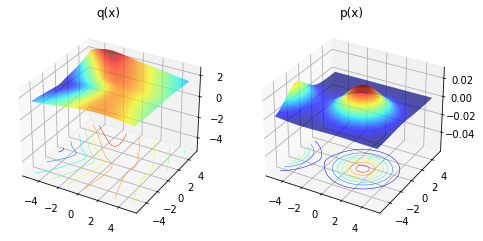

In [42]:
fig_before_train = plot_distributions(tester)

In [43]:
#tester.optimizer = torch.optim.Adam(tester.learnt_sampling_dist.parameters(), lr=1e-4)
# tester.optimizer.param_groups[0]["lr"]

In [44]:
history = tester.train(epochs, batch_size=200)

loss: 1.5778672695159912, mean log p_x -4.291637420654297: 100%|███████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:27<00:00, 18.69it/s]


In [45]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 2.607022285461426 
estimate after training is 11.274141311645508 
effective sample size is 16.716381072998047 
variance in weights is 5.972753115202067e-06


(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

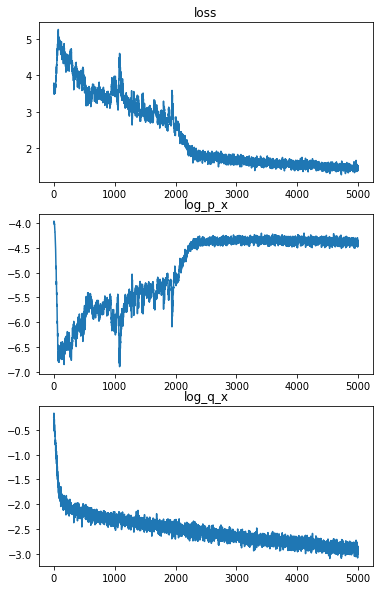

In [46]:
plot_history(history)

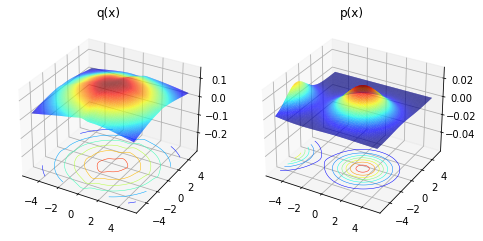

In [47]:
fig_after_train = plot_distributions(tester)

# New Section